# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4615 | MulticlassF1Score=0.1477
Batch-30 : CrossEntropyLoss=2.4763 | MulticlassF1Score=0.2030
Batch-45 : CrossEntropyLoss=2.4514 | MulticlassF1Score=0.2610
Batch-60 : CrossEntropyLoss=2.4112 | MulticlassF1Score=0.3096
Batch-75 : CrossEntropyLoss=2.3755 | MulticlassF1Score=0.3566
Batch-90 : CrossEntropyLoss=2.3521 | MulticlassF1Score=0.4032
Batch-105: CrossEntropyLoss=2.3570 | MulticlassF1Score=0.4395
Batch-120: CrossEntropyLoss=2.3715 | MulticlassF1Score=0.4682
Batch-135: CrossEntropyLoss=2.3408 | MulticlassF1Score=0.4894
Batch-150: CrossEntropyLoss=2.3409 | MulticlassF1Score=0.5072
Batch-165: CrossEntropyLoss=2.3218 | MulticlassF1Score=0.5228
Batch-180: CrossEntropyLoss=2.3364 | MulticlassF1Score=0.5359
Batch-195: CrossEntropyLoss=2.3639 | MulticlassF1Score=0.5465
Batch-210: CrossEntropyLoss=2.3334 | MulticlassF1Score=0.5554
Batch-225: CrossEntropyLoss=2.3376 | MulticlassF1Score=0.5632
Batch-226: CrossEntropyLoss=2.3567 | MulticlassF1Score=0.5635

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3504 | MulticlassF1Score=0.6802
Batch-30 : CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6785
Batch-45 : CrossEntropyLoss=2.3579 | MulticlassF1Score=0.6783
Batch-60 : CrossEntropyLoss=2.3482 | MulticlassF1Score=0.6772
Batch-63 : CrossEntropyLoss=2.3587 | MulticlassF1Score=0.6777

Training   : Mean CrossEntropyLoss = 2.3947 | Mean MulticlassF1Score = 0.4059
Validation : Mean CrossEntropyLoss = 2.3480 | Mean MulticlassF1Score = 0.6791

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3509 | MulticlassF1Score=0.6784
Batch-30 : CrossEntropyLoss=2.3422 | MulticlassF1Score=0.6750
Batch-45 : CrossEntropyLoss=2.3285 | MulticlassF1Score=0.6758
Batch-60 : CrossEntropyLoss=2.3482 | MulticlassF1Score=0.6757
Batch-75 : CrossEntropyLoss=2.3348 | MulticlassF1Score=0.6768
Batch-90 : CrossEntropyLoss=2.3567 | MulticlassF1Score=0.6784
Batch-105: CrossEntropyLoss=2.3377 | MulticlassF1Score=0.6780
Batch-120: CrossEntropyLoss=2.3455 | MulticlassF1Score=0.6773
Batch-135: CrossEntropyLoss=2.3254 | MulticlassF1Score=0.6794
Batch-150: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.6876
Batch-165: CrossEntropyLoss=2.3242 | MulticlassF1Score=0.6959
Batch-180: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7037
Batch-195: CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7090
Batch-210: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7148
Batch-225: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.7192
Batch-226: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7193

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7913
Batch-30 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7866
Batch-45 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7856
Batch-60 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7881
Batch-63 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7885

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3357 | Mean MulticlassF1Score = 0.6875
Validation : Mean CrossEntropyLoss = 2.3141 | Mean MulticlassF1Score = 0.7865

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.7907
Batch-30 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7915
Batch-45 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7918
Batch-60 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7923
Batch-75 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7927
Batch-90 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7926
Batch-105: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7925
Batch-120: CrossEntropyLoss=2.3310 | MulticlassF1Score=0.7925
Batch-135: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7922
Batch-150: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7923
Batch-165: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7925
Batch-180: CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7923
Batch-195: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7919
Batch-210: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7925
Batch-225: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7929
Batch-226: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7930

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7927
Batch-30 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7927
Batch-45 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7923
Batch-60 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7931
Batch-63 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.7939

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7920
Validation : Mean CrossEntropyLoss = 2.3118 | Mean MulticlassF1Score = 0.7930

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7968
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.7976
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7982
Batch-60 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7987
Batch-75 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7976
Batch-90 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7973
Batch-105: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.7979
Batch-120: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.7975
Batch-135: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7971
Batch-150: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.7981
Batch-165: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7991
Batch-180: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.7996
Batch-195: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7999
Batch-210: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8007
Batch-225: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8009
Batch-226: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.8009

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.8092
Batch-30 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8112
Batch-45 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8075
Batch-60 : CrossEntropyLoss=2.3189 | MulticlassF1Score=0.8055
Batch-63 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8059

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3096 | Mean MulticlassF1Score = 0.7978
Validation : Mean CrossEntropyLoss = 2.3080 | Mean MulticlassF1Score = 0.8074

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8096
Batch-30 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8067
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8095
Batch-60 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8141
Batch-75 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8180
Batch-90 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8205
Batch-105: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8229
Batch-120: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8251
Batch-135: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8264
Batch-150: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8283
Batch-165: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8293
Batch-180: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8299
Batch-195: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8311
Batch-210: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8319
Batch-225: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8320
Batch-226: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8380
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8387
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8384
Batch-60 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8358
Batch-63 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8219
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8380

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8399
Batch-30 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8388
Batch-45 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8398
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8401
Batch-75 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8395
Batch-90 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8402
Batch-105: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8405
Batch-120: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8408
Batch-135: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8412
Batch-150: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8406
Batch-165: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8405
Batch-180: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8404
Batch-195: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8407
Batch-210: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8406
Batch-225: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8403
Batch-226: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8355
Batch-30 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8352
Batch-45 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8359
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8398
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8351

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8423
Batch-30 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8409
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8437
Batch-60 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8443
Batch-75 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8440
Batch-90 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8436
Batch-105: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8437
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8438
Batch-135: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8430
Batch-150: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8426
Batch-165: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8420
Batch-180: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8415
Batch-195: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8415
Batch-210: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8417
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8417
Batch-226: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8363
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8375
Batch-60 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8375
Batch-63 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2967 | Mean MulticlassF1Score = 0.8426
Validation : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8362

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8416
Batch-30 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8461
Batch-45 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8490
Batch-60 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8499
Batch-75 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8518
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8534
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8532
Batch-120: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8539
Batch-135: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8544
Batch-150: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8546
Batch-165: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8555
Batch-180: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8558
Batch-195: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8562
Batch-210: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8565
Batch-225: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8563
Batch-226: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8563

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8604
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8565
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8546
Batch-60 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8536
Batch-63 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8536

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8518
Validation : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8576

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8542
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8569
Batch-45 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8586
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8598
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8601
Batch-90 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8608
Batch-105: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8598
Batch-120: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8608
Batch-135: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8629
Batch-150: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8650
Batch-165: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8667
Batch-180: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8686
Batch-195: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8698
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8712
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8723
Batch-226: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8724

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8794
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8795
Batch-45 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8789
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8780
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8784

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2875 | Mean MulticlassF1Score = 0.8625
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8798

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8877
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8884
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8875
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8868
Batch-75 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8863
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8871
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8880
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8885
Batch-135: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8890
Batch-150: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8891
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8890
Batch-180: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8892
Batch-195: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8893
Batch-210: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8895
Batch-225: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8892
Batch-226: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8893

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8833
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8833
Batch-45 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8822
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8815
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8819

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8882
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8846

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8932
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8935
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8947
Batch-90 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8937
Batch-105: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8936
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8929
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8924
Batch-150: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8926
Batch-165: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8924
Batch-180: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8923
Batch-195: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8927
Batch-210: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8926
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8924
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8925

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8833
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8841
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8843

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8933
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8852

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8948
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8966
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8952
Batch-75 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8956
Batch-90 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8950
Batch-105: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8951
Batch-120: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8953
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8956
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8955
Batch-165: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8951
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8950
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8951
Batch-225: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8949
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8950

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8878
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8849
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8851

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8949
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8873

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8994
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8979
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8971
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8960
Batch-75 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8966
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8969
Batch-105: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8971
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8974
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8970
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8972
Batch-165: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8973
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8973
Batch-195: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8972
Batch-210: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8971
Batch-225: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8972
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8972

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8853
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8972
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8847

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8998
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8995
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8994
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8995
Batch-105: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8991
Batch-120: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8992
Batch-135: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8992
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8987
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8990
Batch-195: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8986
Batch-210: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8986
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8987
Batch-226: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8987

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8865
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8993
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8867

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9013
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9047
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9023
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.9021
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9012
Batch-90 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9006
Batch-105: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9008
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9001
Batch-135: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8998
Batch-150: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9000
Batch-165: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8996
Batch-180: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8995
Batch-195: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8994
Batch-210: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8993
Batch-225: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8995
Batch-226: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8995

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8859
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.9003
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8848

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9039
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9026
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9016
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9006
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9019
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9016
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9019
Batch-120: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9016
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9014
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9013
Batch-165: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9019
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9020
Batch-195: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9019
Batch-210: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9018
Batch-225: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.9019
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9019

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8894
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8905
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8903
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8904

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9017
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8909

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9074
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9066
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9067
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9064
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9055
Batch-90 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9061
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9061
Batch-120: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9059
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9056
Batch-150: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9055
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9056
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9054
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9055
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9054
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9051
Batch-226: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9051

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8852
Batch-30 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8898
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8910
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8903
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2770 | Mean MulticlassF1Score = 0.9058
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8896

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9084
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9070
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9056
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9068
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9071
Batch-90 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9073
Batch-105: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9077
Batch-120: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9073
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9072
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9073
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9073
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9069
Batch-195: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9067
Batch-210: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9068
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9068
Batch-226: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9068

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8983
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8916
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8899
Batch-63 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8902

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9069
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8932

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9091
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9075
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9078
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9088
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9088
Batch-105: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9085
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9085
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9084
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9082
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9084
Batch-180: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9080
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9078
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9080
Batch-225: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9077
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9077

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8899
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8911
Batch-63 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8908

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9082
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8900

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9084
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9081
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9090
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9085
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9082
Batch-90 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9077
Batch-105: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9077
Batch-120: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9081
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9082
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9083
Batch-165: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9083
Batch-180: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9082
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9083
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9082
Batch-225: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9081
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9081

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8921
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8910
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8914
Batch-63 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8910

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9083
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8936

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9111
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9117
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9113
Batch-75 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9109
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9103
Batch-105: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9095
Batch-120: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9090
Batch-135: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9088
Batch-150: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9089
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9089
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9092
Batch-195: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9090
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9088
Batch-225: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9088
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9088

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8938
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8959
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8940
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8941

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9098
Validation : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8954

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9126
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9109
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9123
Batch-75 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9119
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9121
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9123
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9120
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9120
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9125
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9125
Batch-180: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9126
Batch-195: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9126
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9131
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9131
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9131

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9003
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8954
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8954
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8951
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8952

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9122
Validation : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8960

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9113
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9119
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9122
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9134
Batch-75 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9133
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9135
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9140
Batch-120: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9139
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9139
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9145
Batch-165: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9142
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9141
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9139
Batch-210: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9139
Batch-225: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9140
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9140

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8936
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8952
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8955
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8956
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8959

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9138
Validation : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8942

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9097
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9119
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9142
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9151
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9148
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9157
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9153
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9156
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9153
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9149
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9147
Batch-195: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9148
Batch-210: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9148
Batch-225: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9149
Batch-226: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9149

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8978
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.8943
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8946
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8967
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8962

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9143
Validation : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8954

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9145
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9156
Batch-90 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9152
Batch-105: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9155
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9155
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9152
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9163
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9181
Batch-180: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9198
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9218
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9236
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9245
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9245

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9177
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9268

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9439
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9437
Batch-150: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9246

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9243

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9439
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9245

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9245

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9461
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9452
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9452
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9452

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9257

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9457
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9457
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9266

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9490
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9503
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9517
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9528
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9536
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9544
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9545

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2616 | Mean MulticlassF1Score = 0.9482
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9442

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9639
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9648
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9653
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9655
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9649
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9447

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9448

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9658
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9655
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9445
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9450

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9665
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9455

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9476

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9643
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9650
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9665
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9447

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9673
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9670
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9669
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9459

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9460

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9472

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9470

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9467

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9449
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9445

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9460
Patience = 1/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9466

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9478
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9461

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9732
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9466

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9495

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9722
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9729
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9725
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9712
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9471

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9718
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9714
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9714

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9713
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9713
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9486

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9731
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9728
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9721
Batch-120: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9723
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2510 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9723
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9500

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9712
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9714
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9716
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9461

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2637
Best MulticlassF1Score validation : 0.9712
Best MulticlassF1Score validation : 0.9461
Training duration                 : 2.7937 minutes.
Training date                     : 2022-10-19 14:52:52.251139+08:00


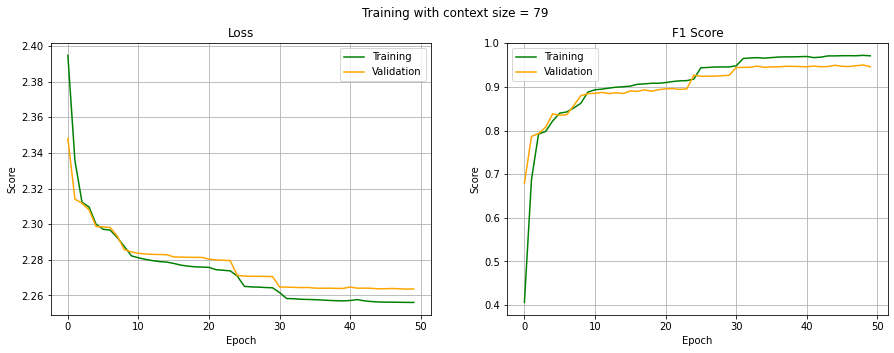

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9722, device='cuda:0'),
 tensor(0.9474, device='cuda:0'),
 tensor(0.9506, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9722, device='cuda:0'),
 tensor(0.9474, device='cuda:0'),
 tensor(0.9506, device='cuda:0'))

## Heatmap

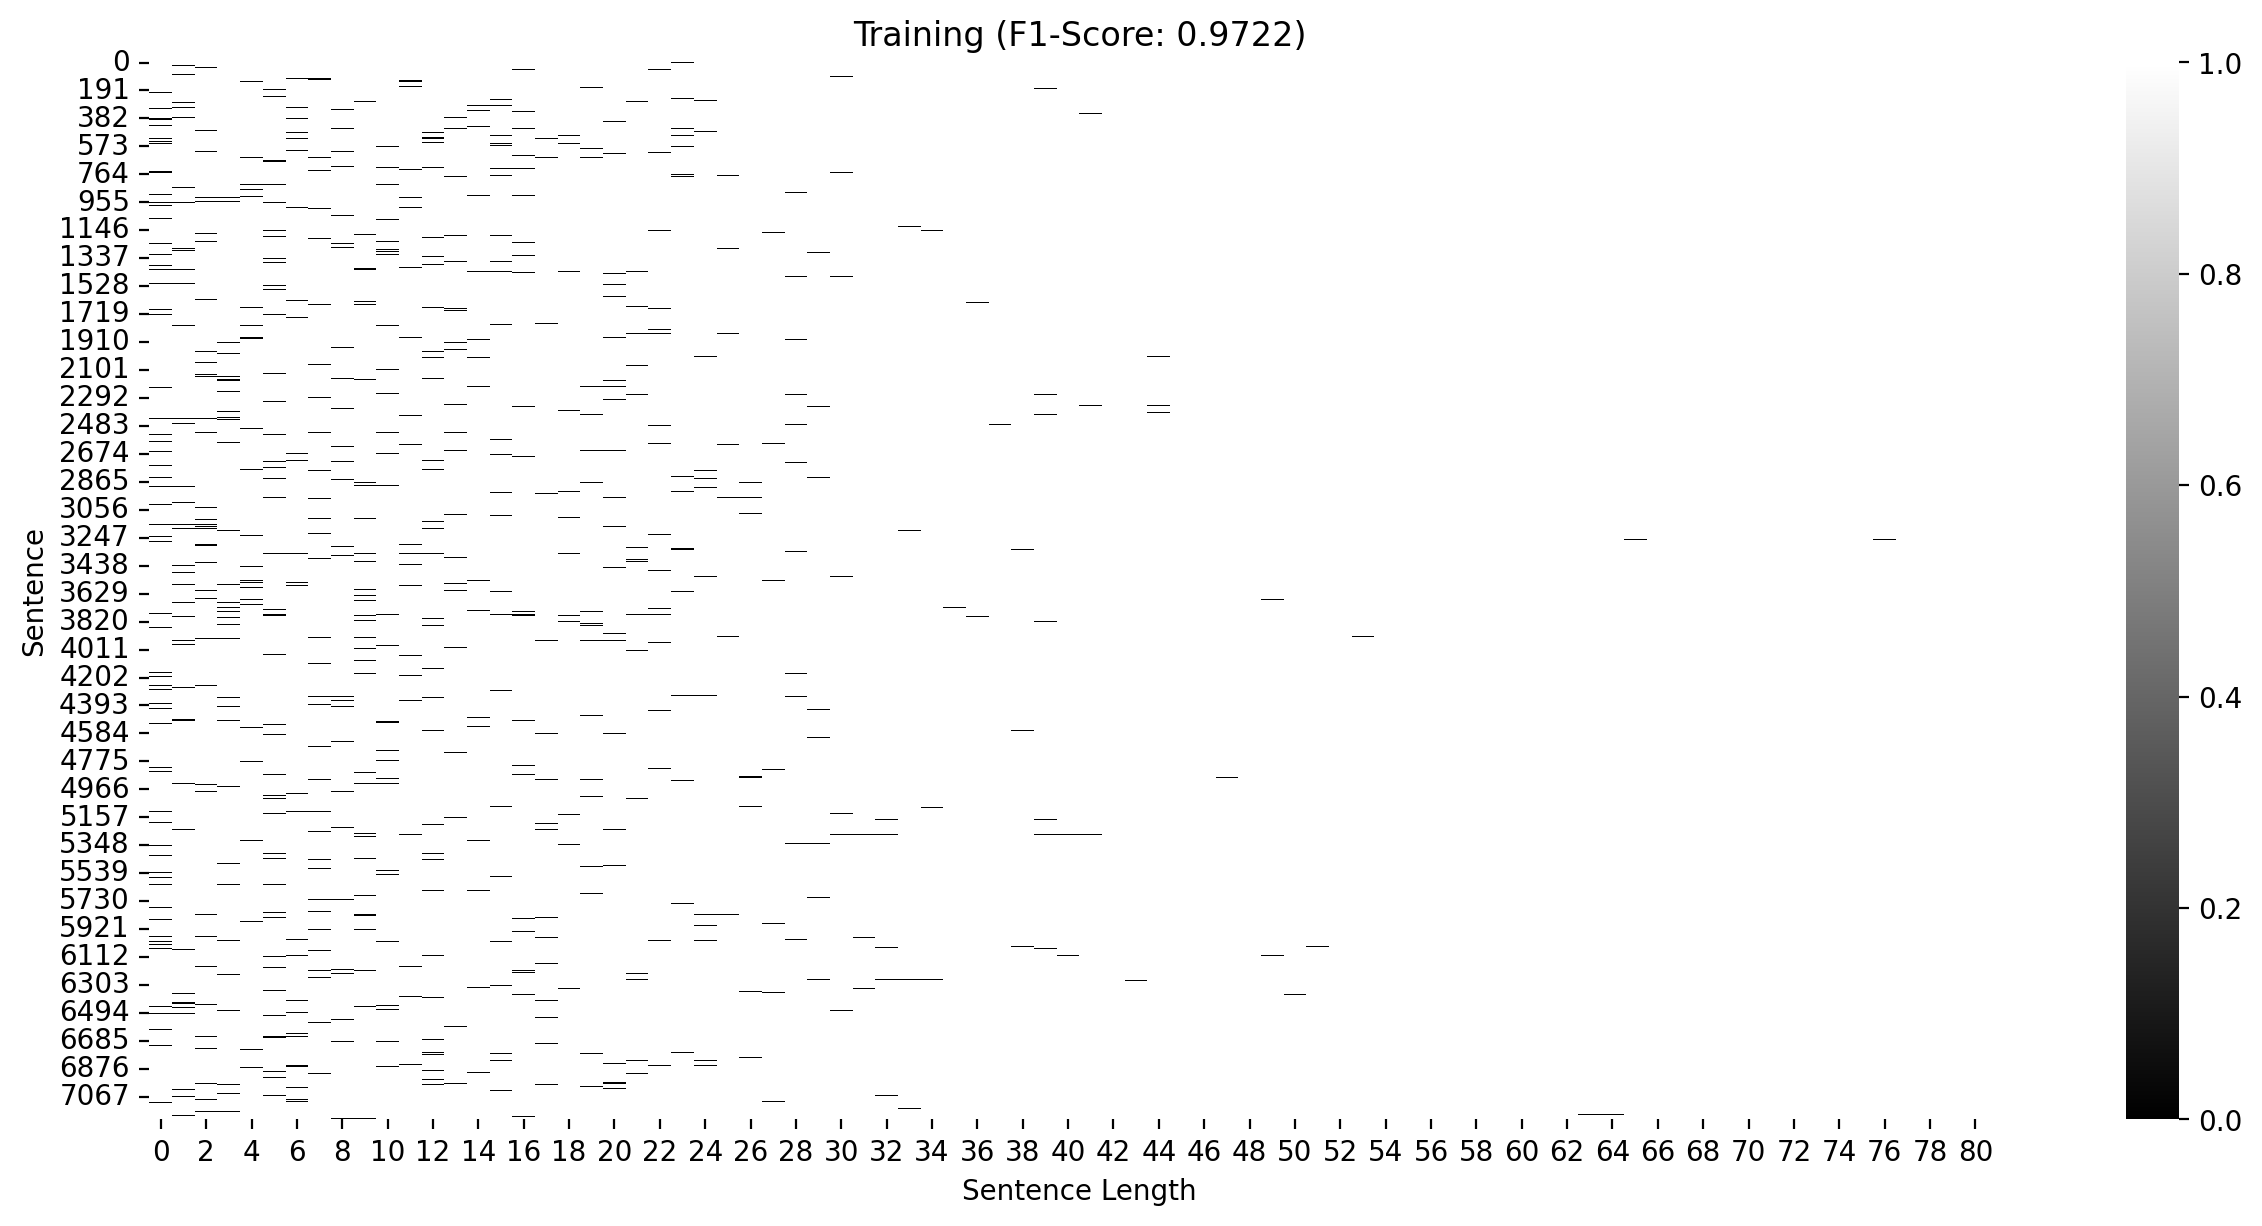

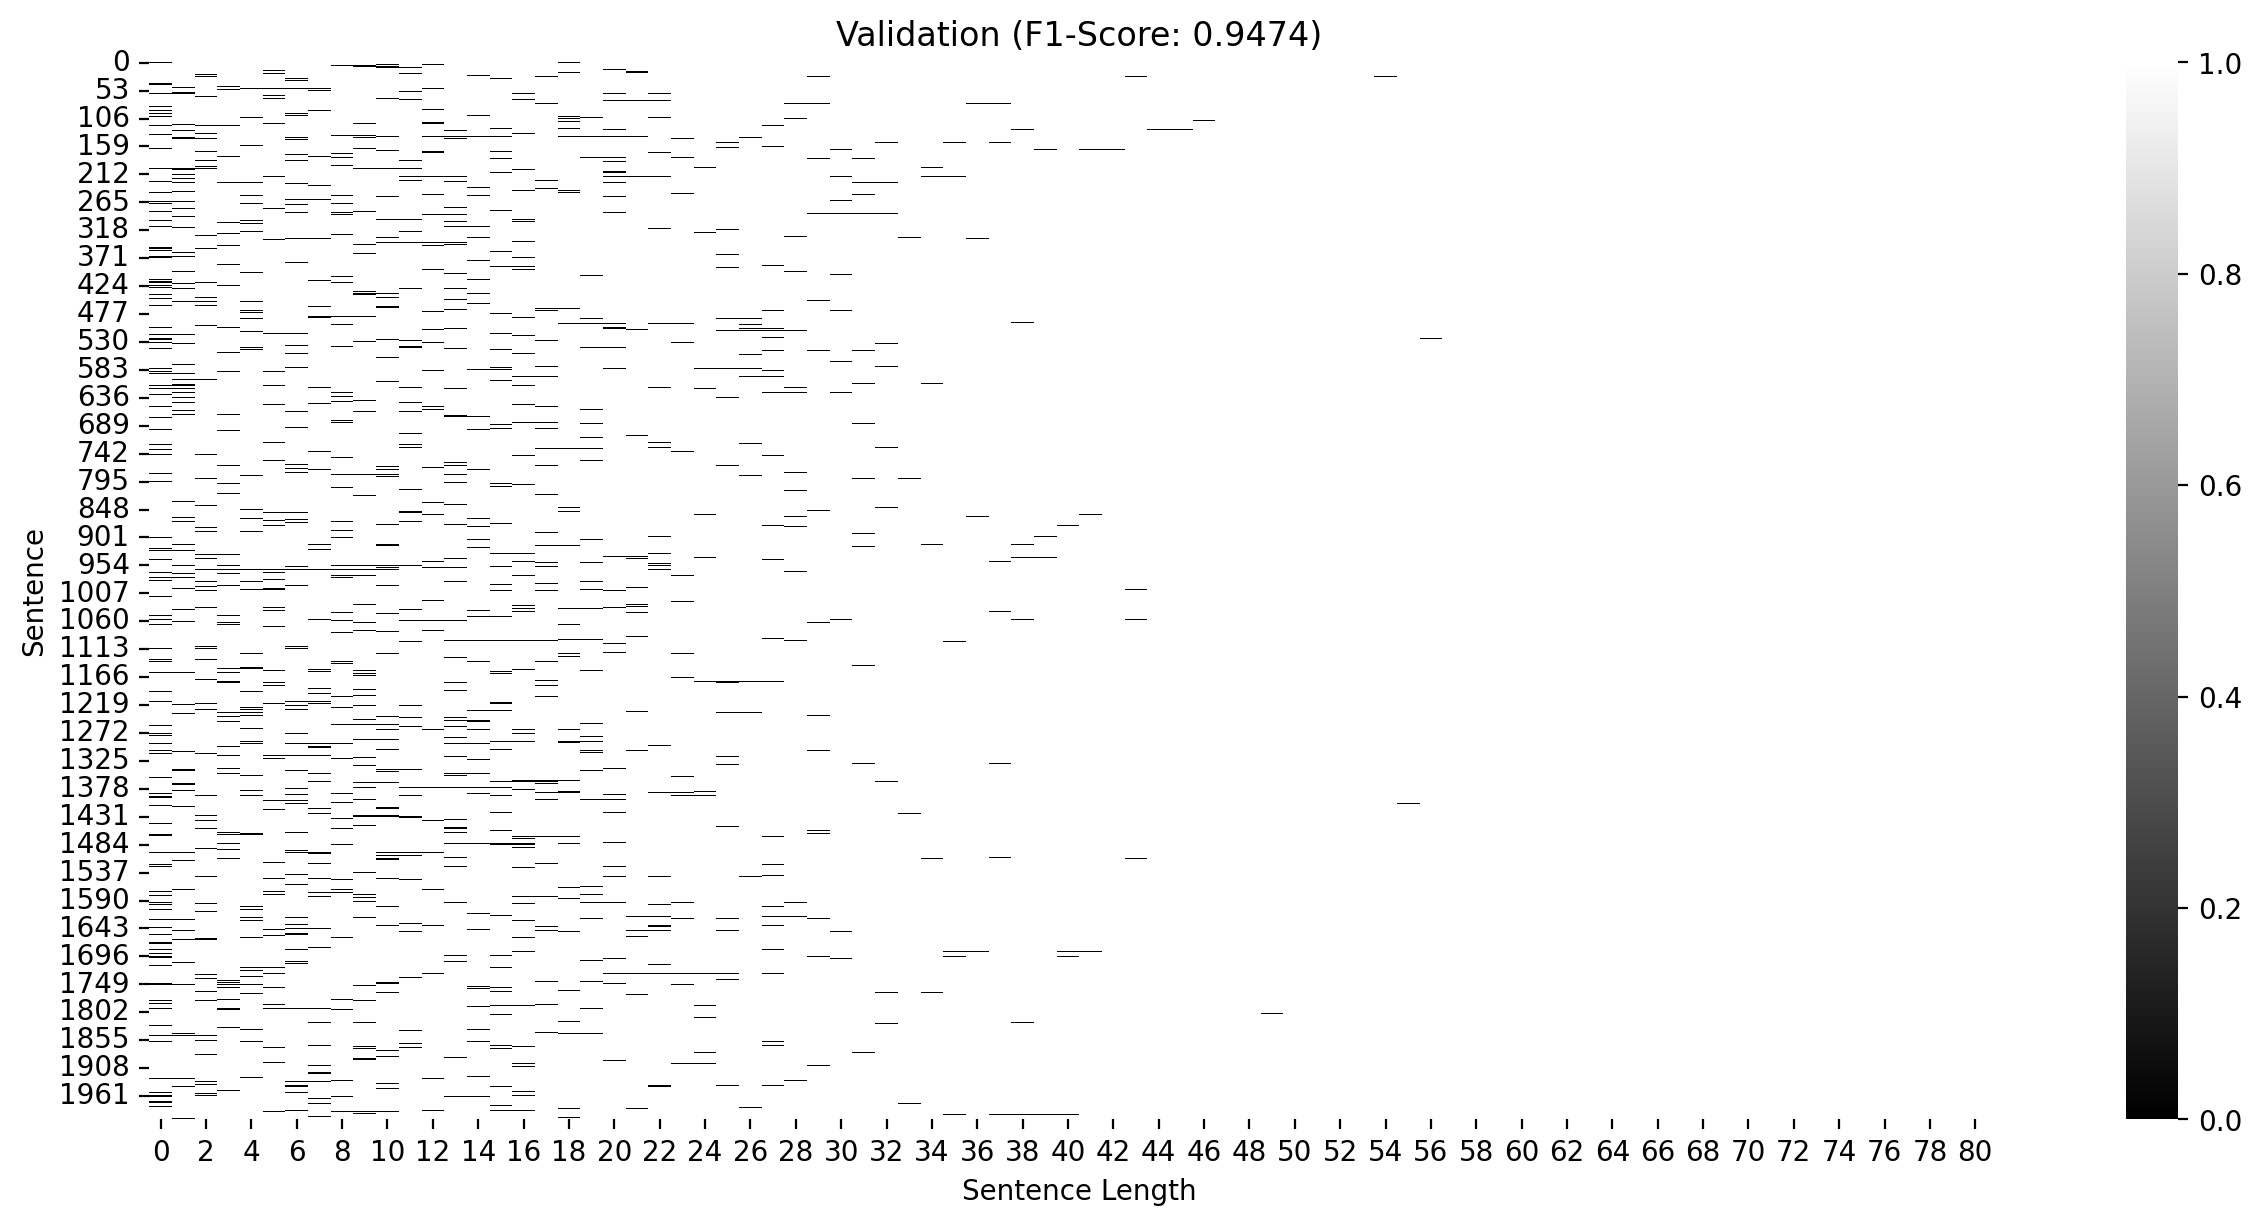

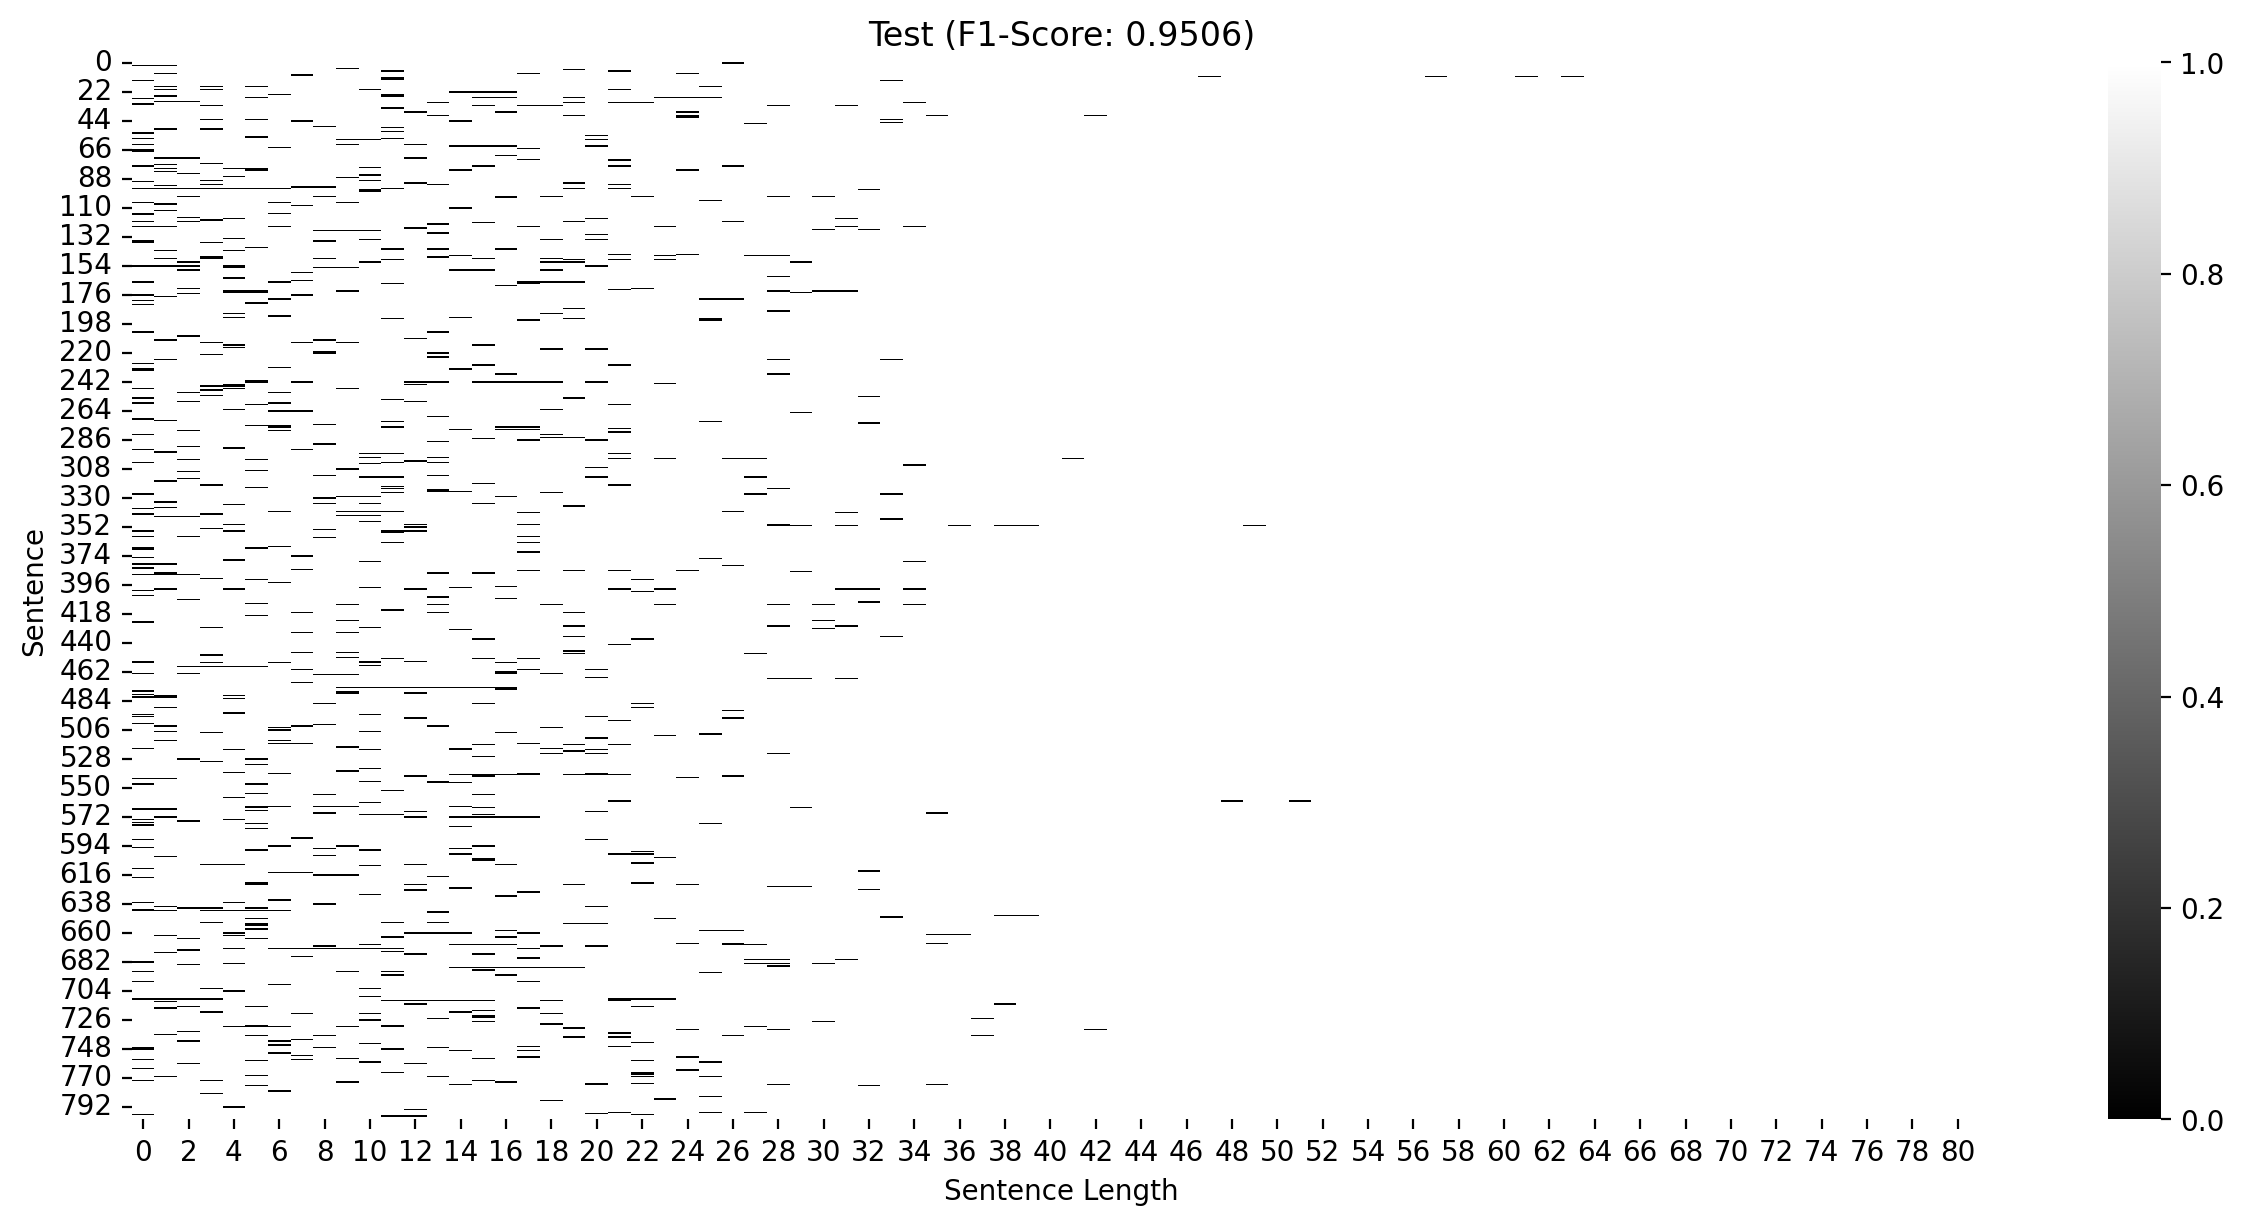

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


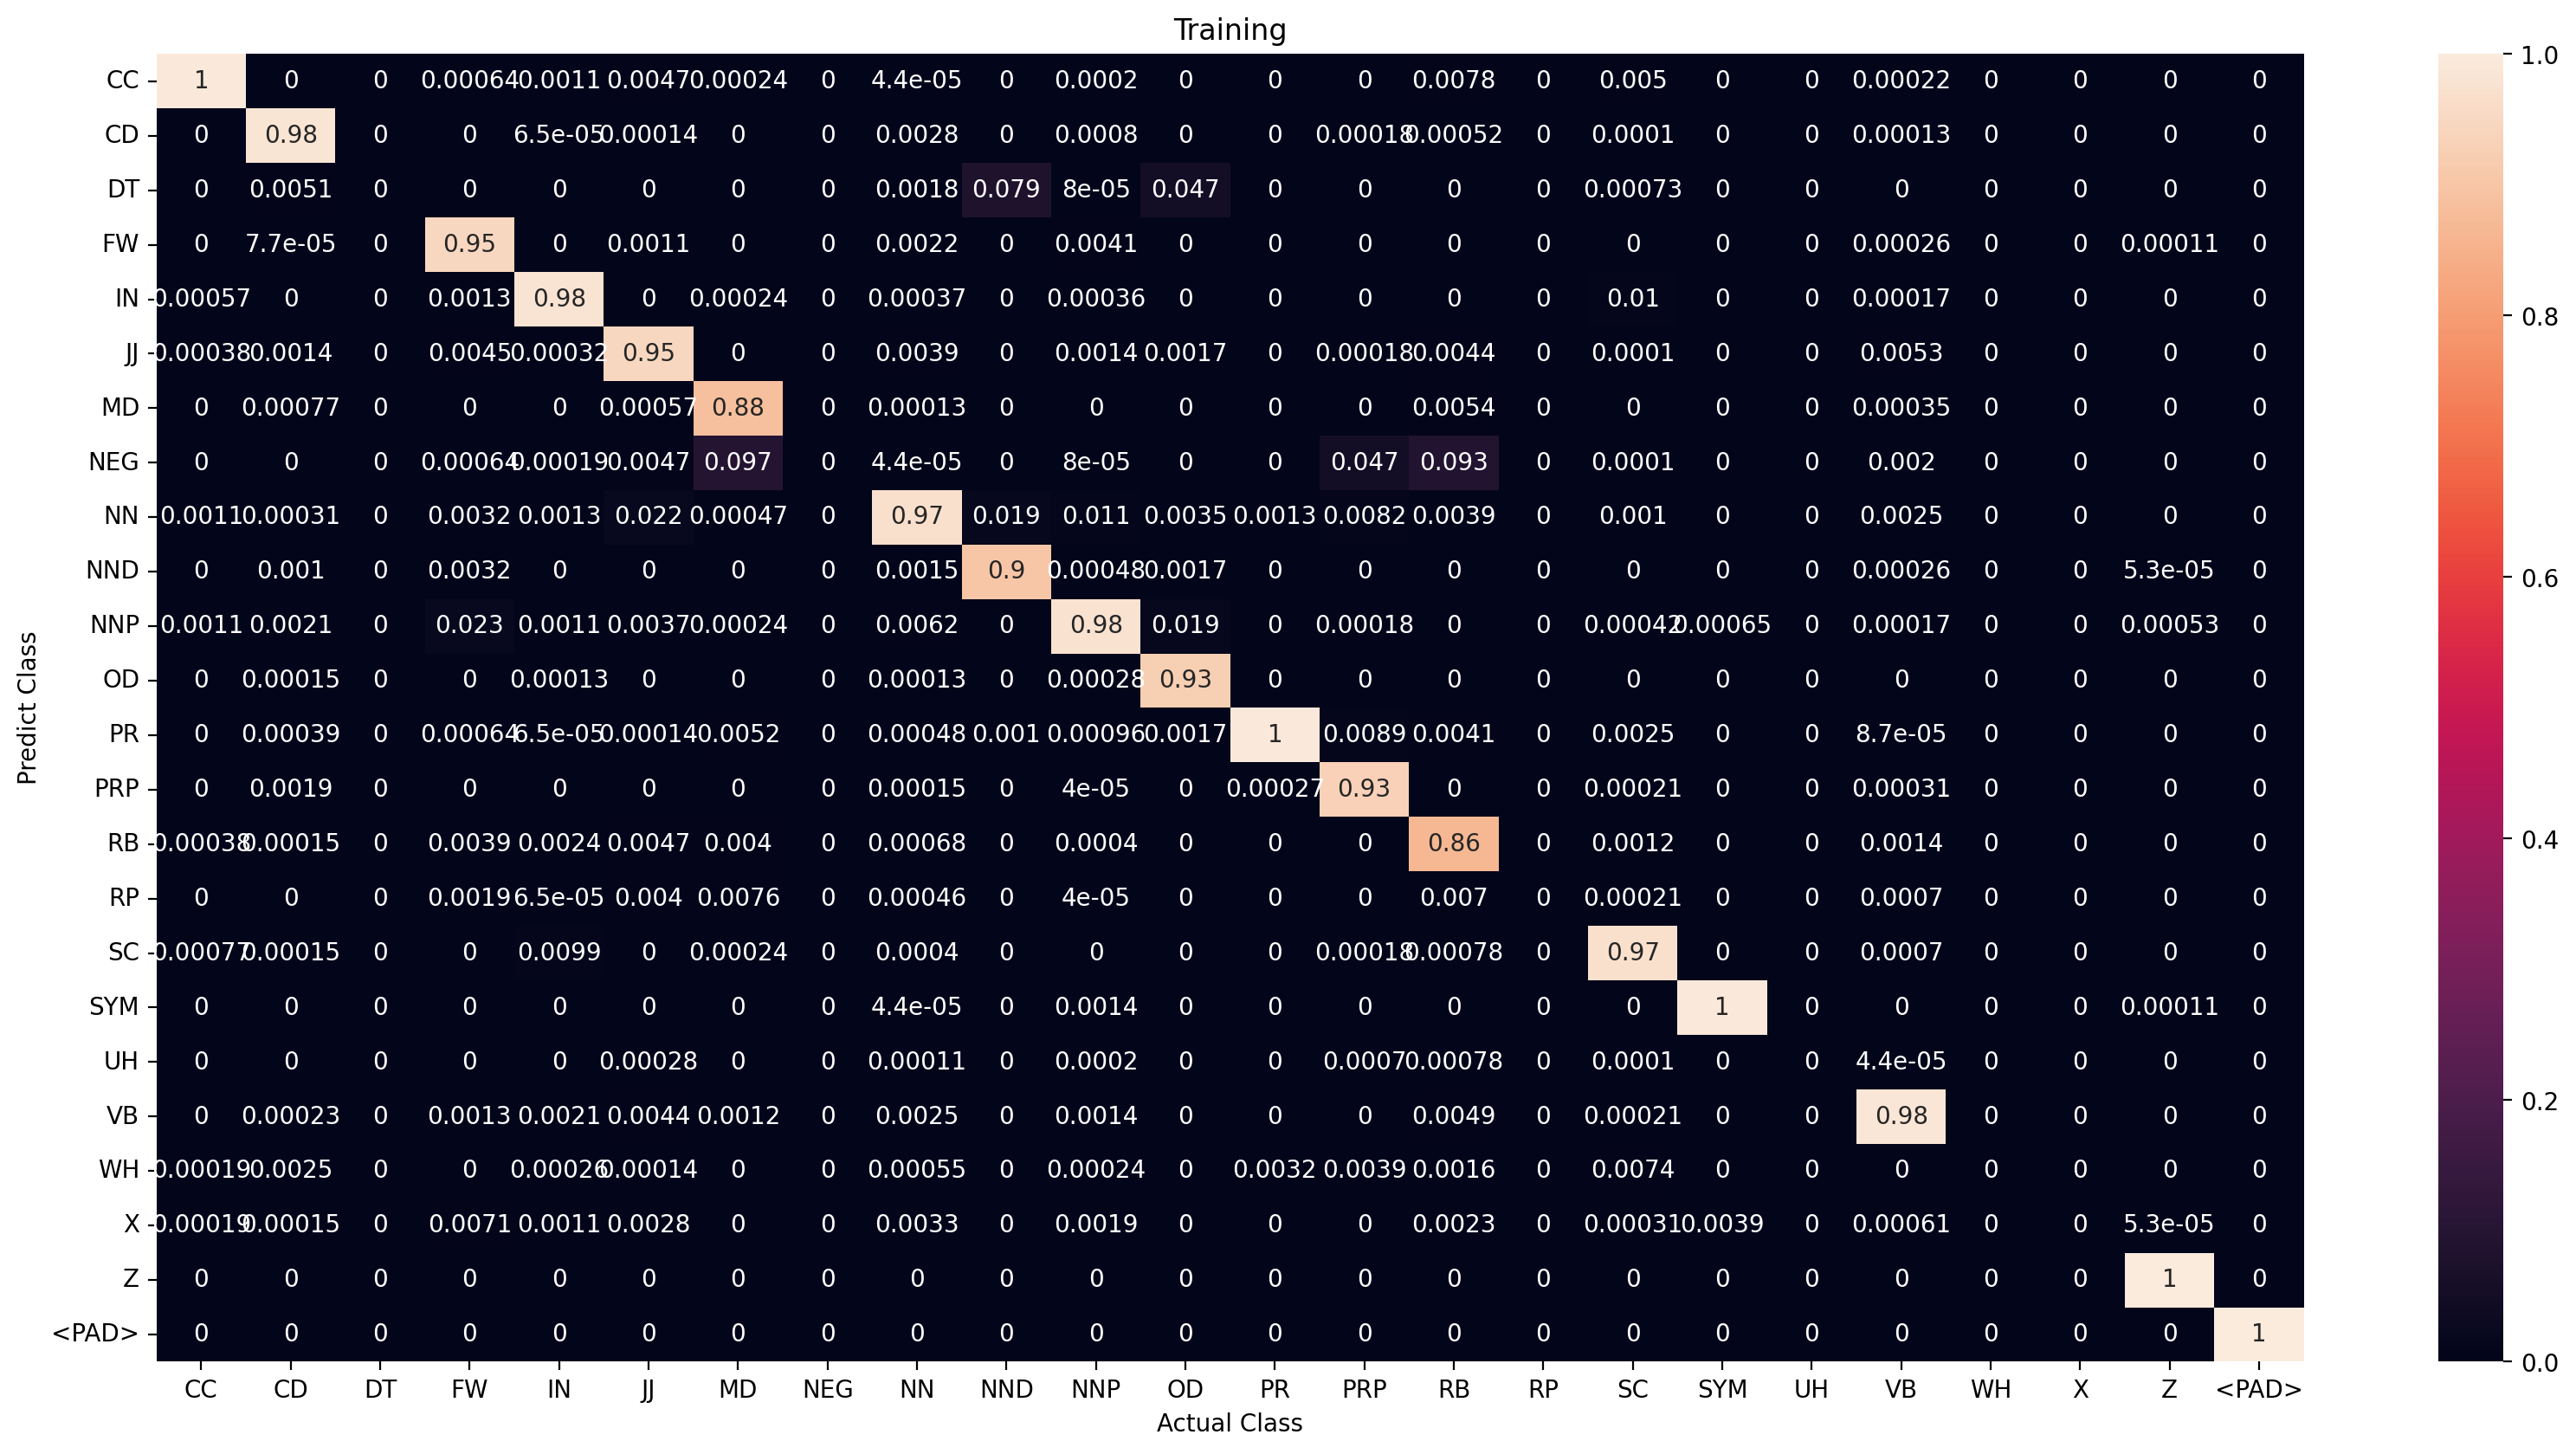

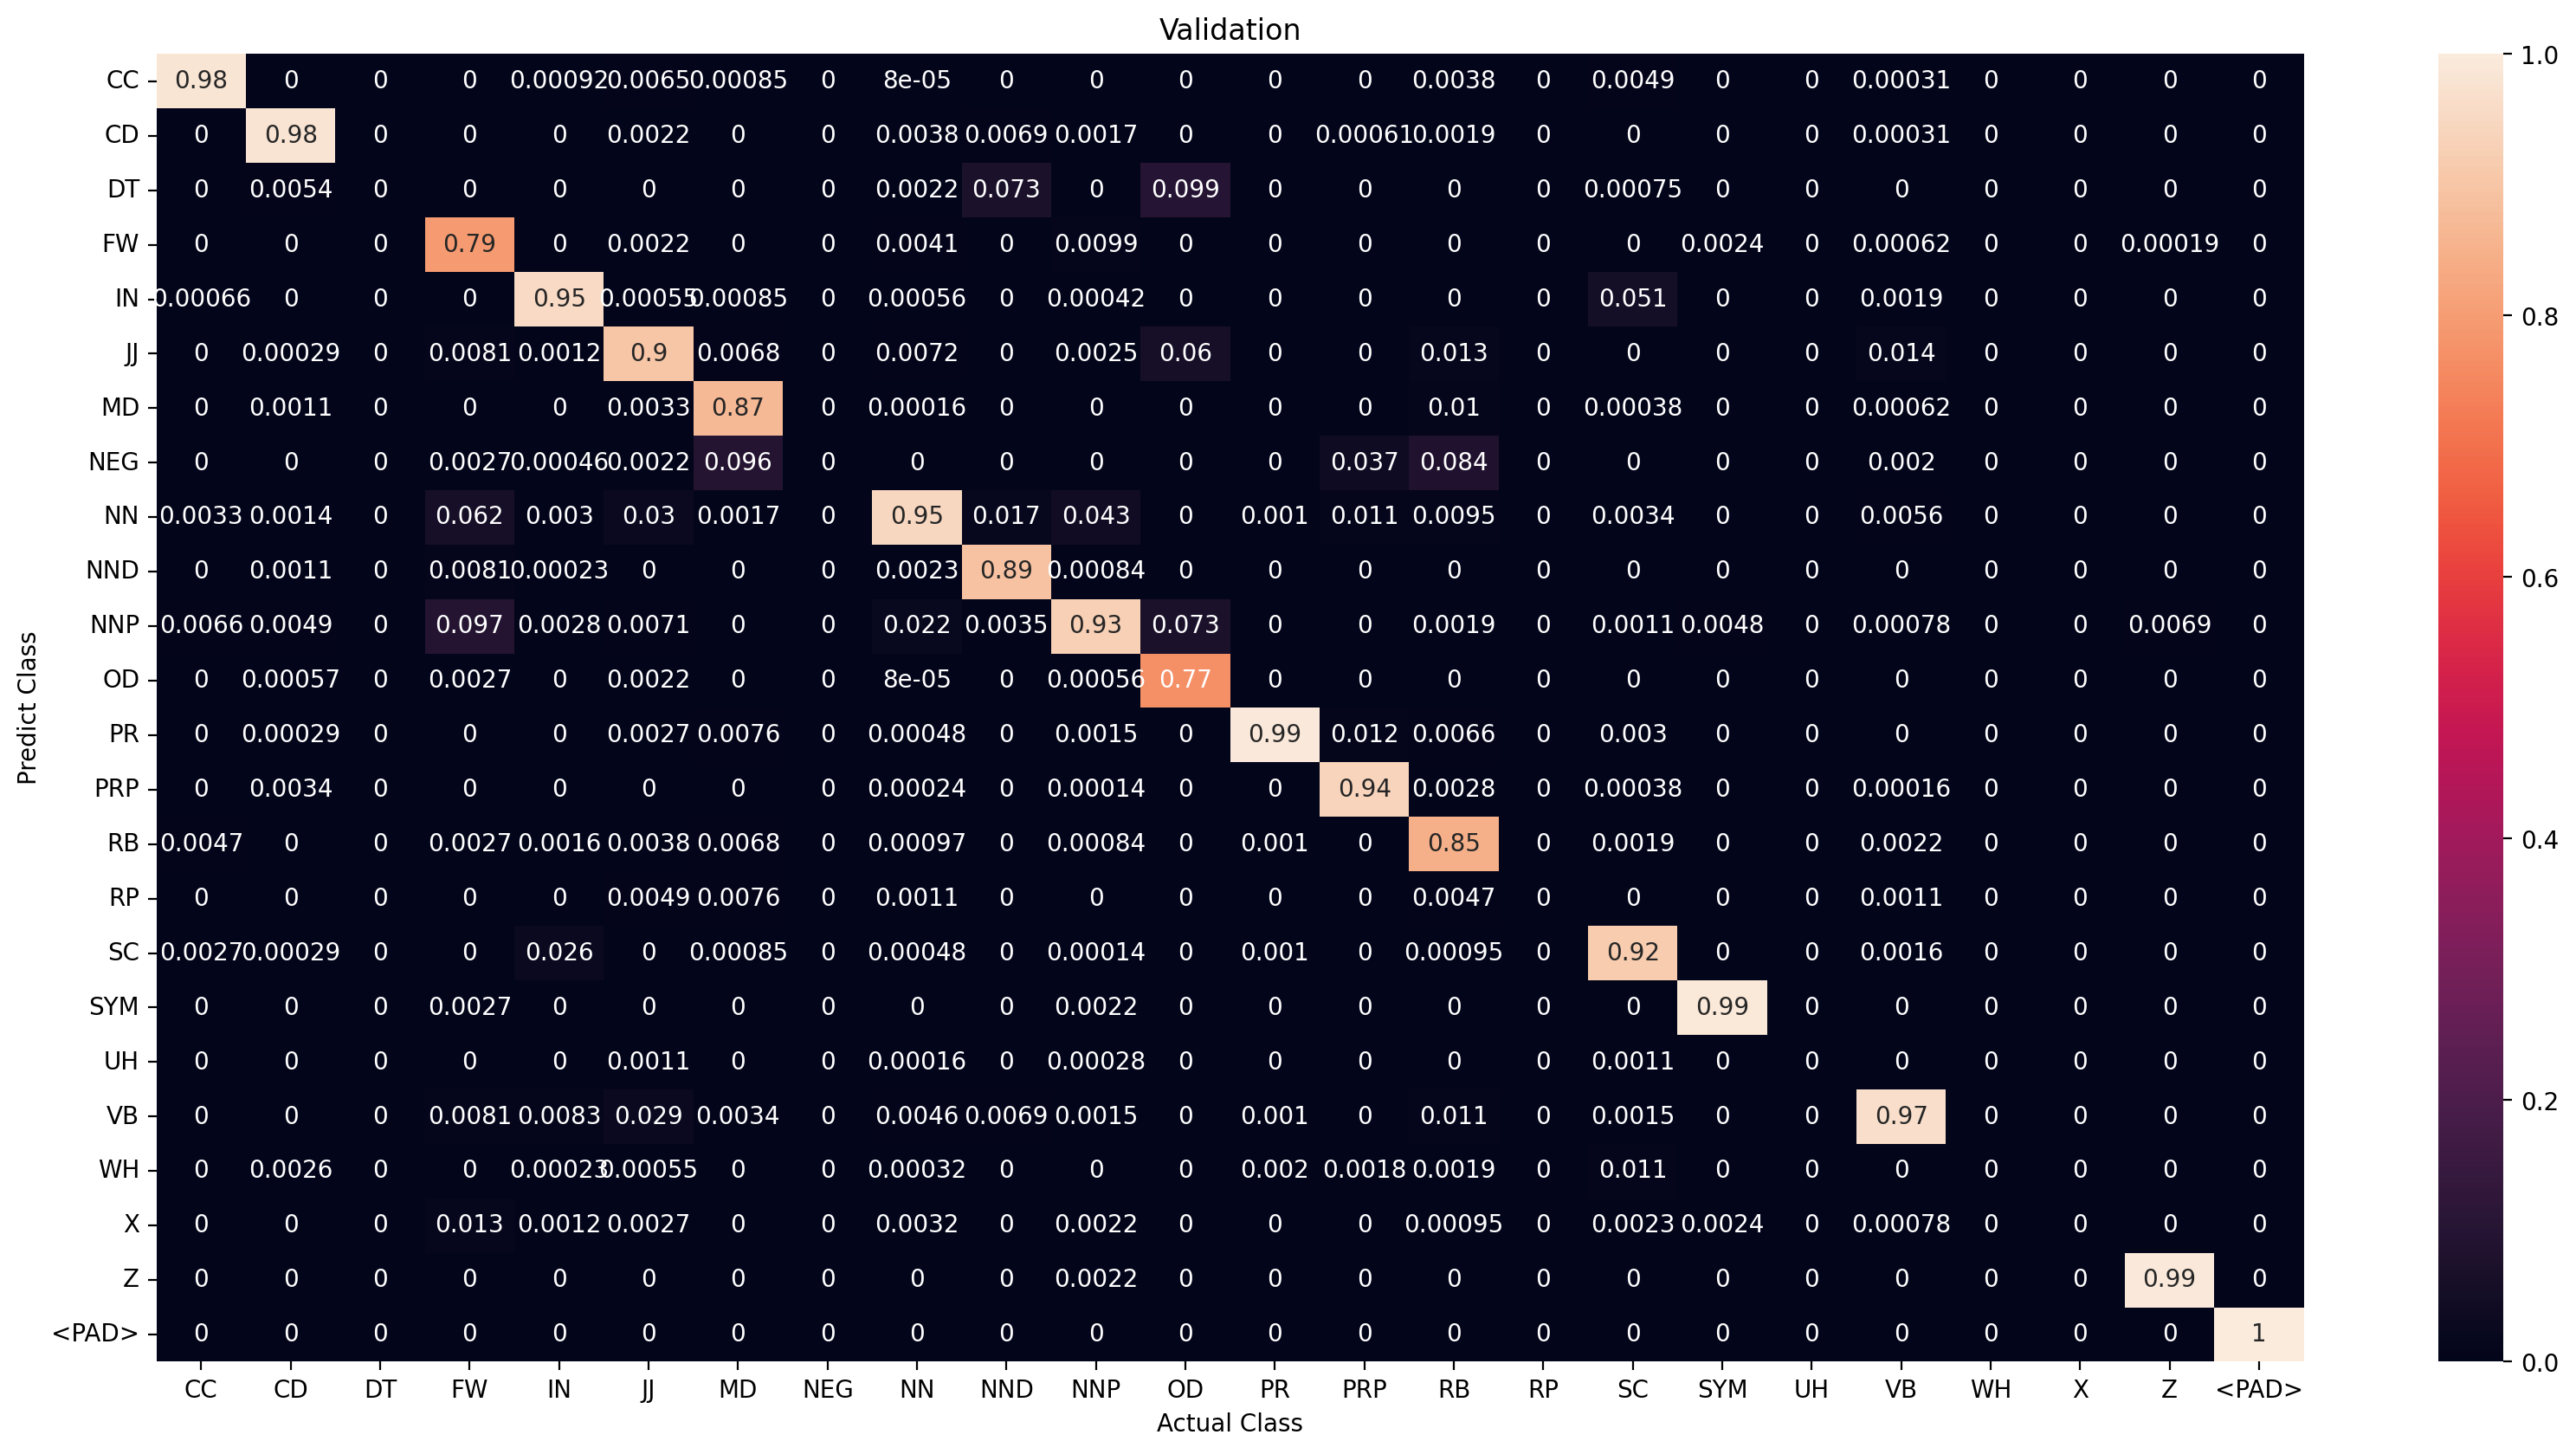

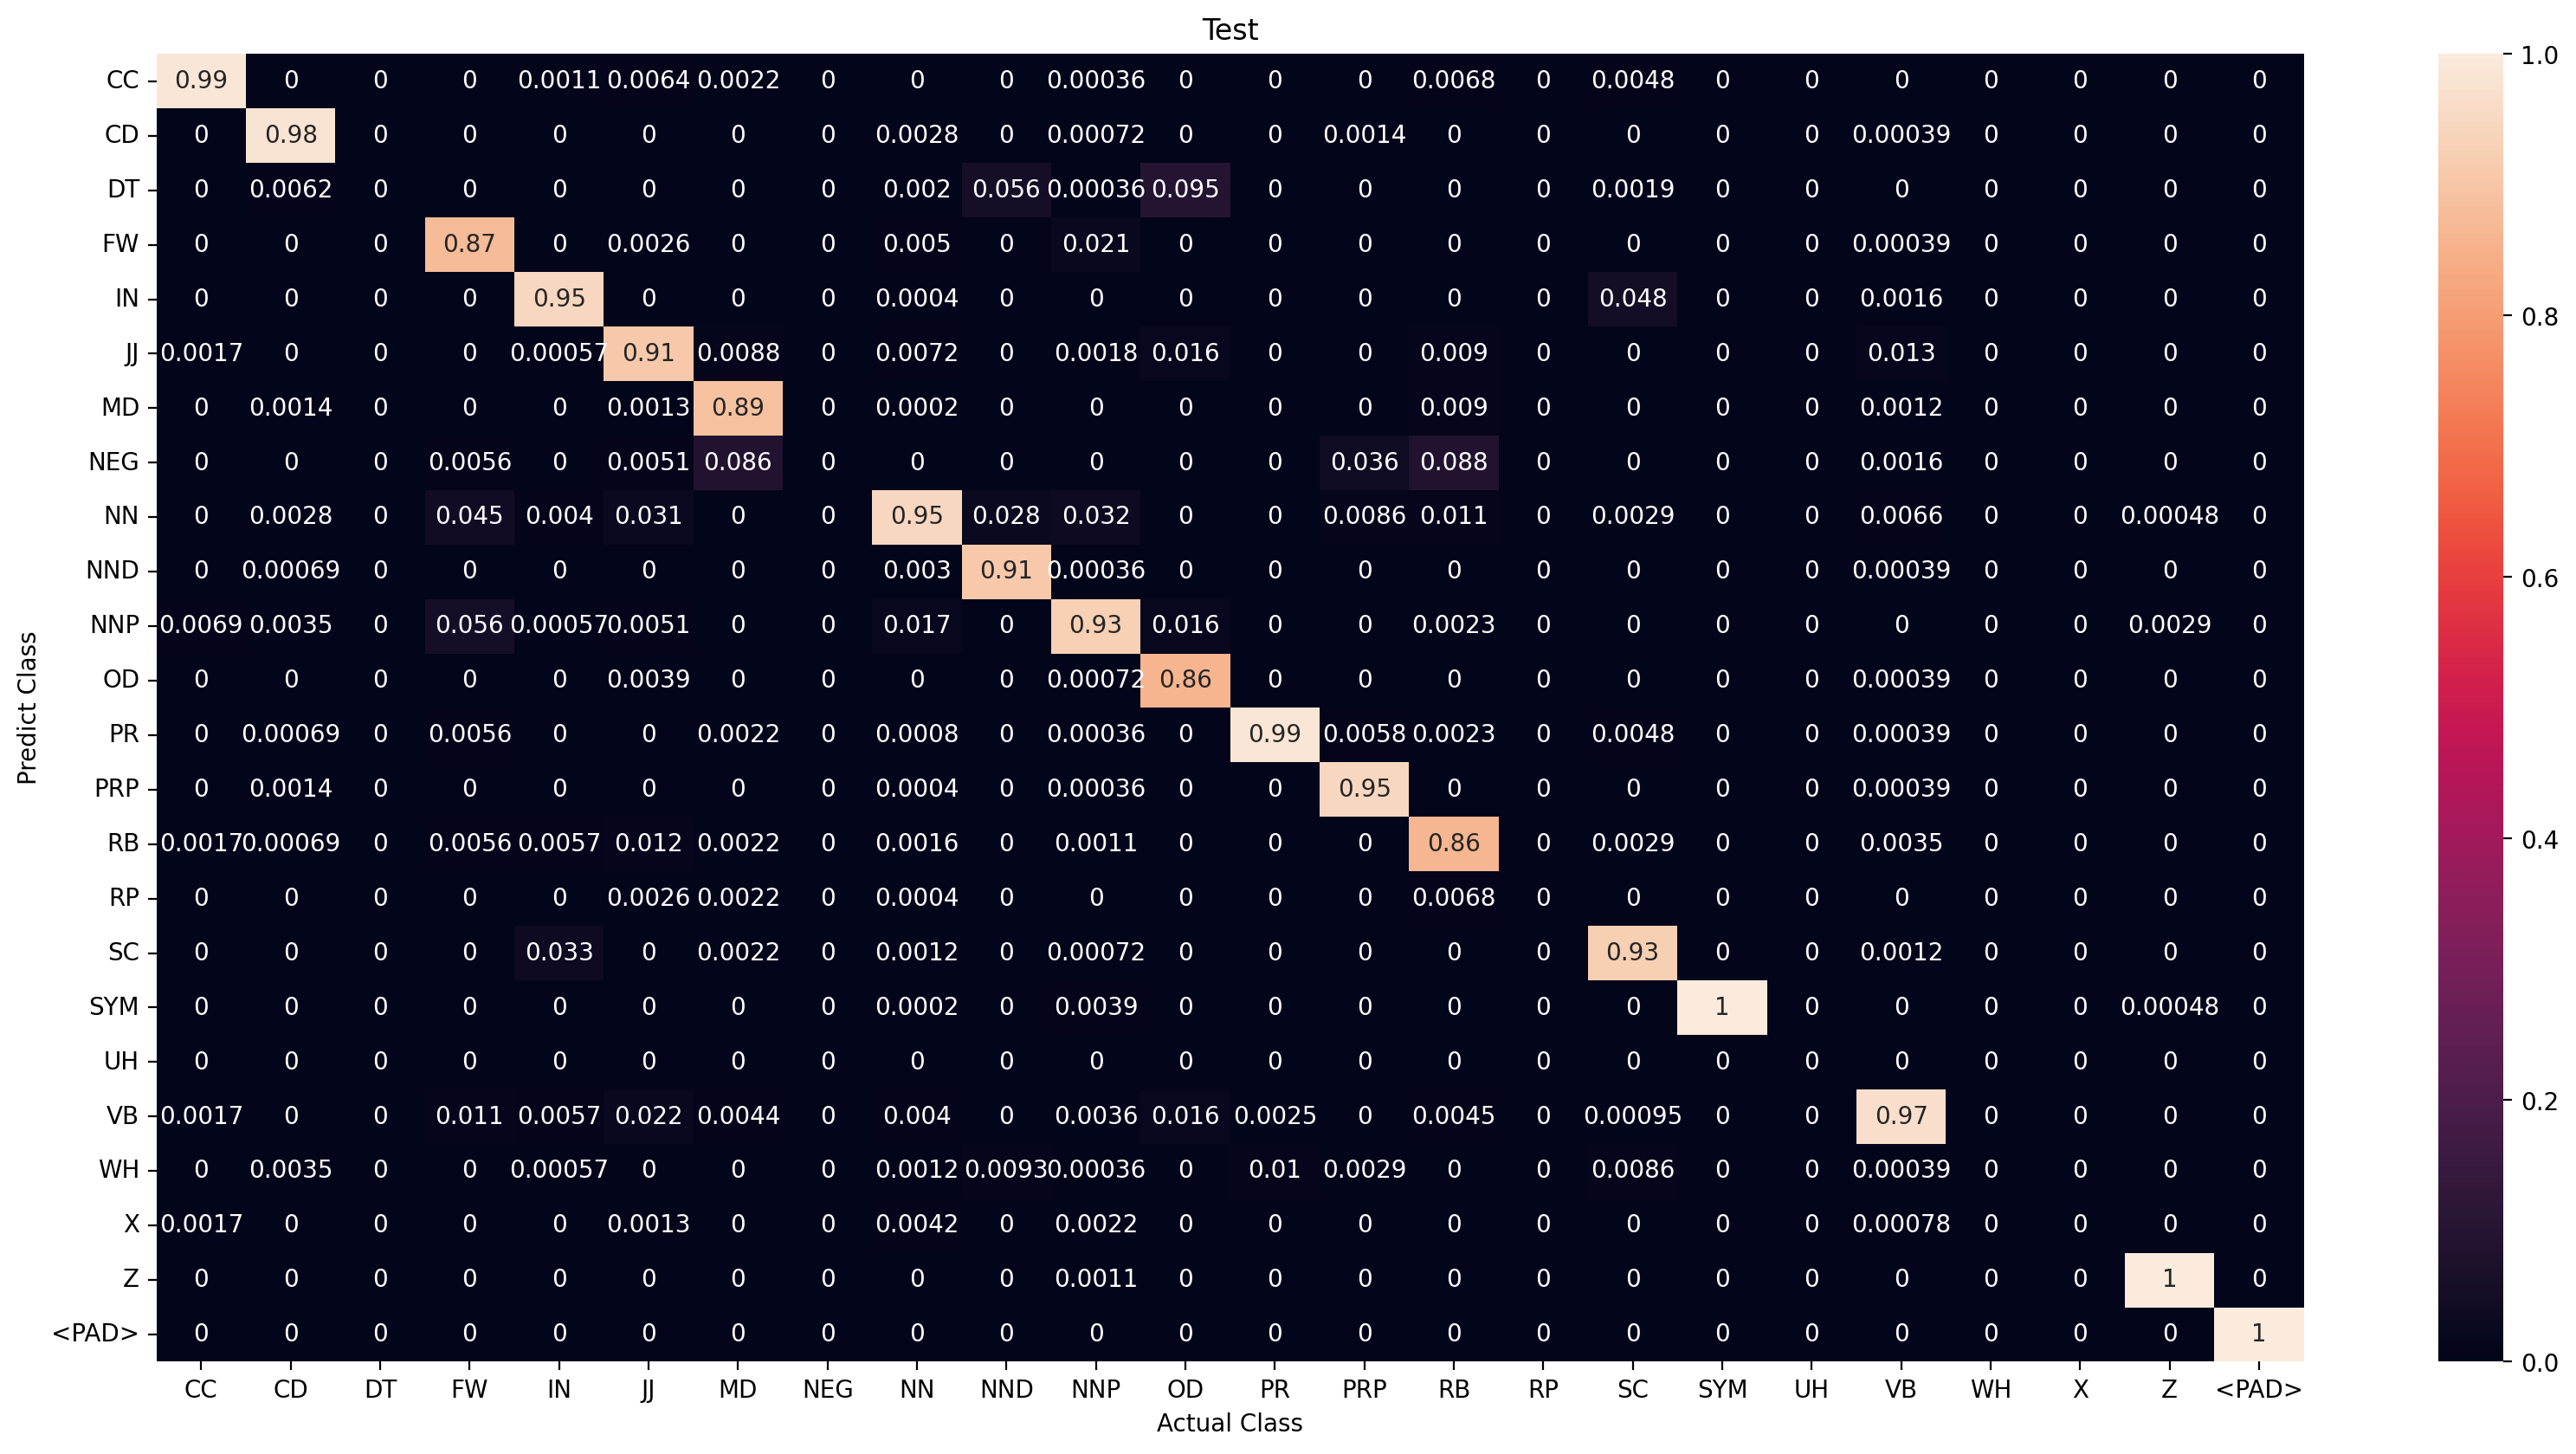

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5194       | CC    : 142      |
| CD    : 12904  | CD    : 12750      | CD    : 154      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1475       | FW    : 222      |
| IN    : 15290  | IN    : 15154      | IN    : 136      |
| JJ    : 7049   | JJ    : 6662       | JJ    : 387      |
| MD    : 3783   | MD    : 3734       | MD    : 49       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44152      | NN    : 617      |
| NND   : 998    | NND   : 894        | NND   : 104      |
| NNP   : 24884  | NNP   : 24457      | NNP   : 427      |
| OD    : 550    | OD    : 533        | OD    : 17       |
| PR    : 3878   | PR    : 3707       | PR    : 171      |
| PRP   : 5355   | PRP   : 5313       | PRP   : 42       |
| RB    : 3517   | RB    : 3335       | RB    : 182      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11212
Wrong prediction            : 722
Percentage correct oov pred : 93.950058655941

Validation
Number OOV token            : 3261
Correct prediction          : 2903
Wrong prediction            : 358
Percentage correct oov pred : 89.02177246243484

Test
Number OOV token            : 1367
Correct prediction          : 1227
Wrong prediction            : 140
Percentage correct oov pred : 89.75859546452085



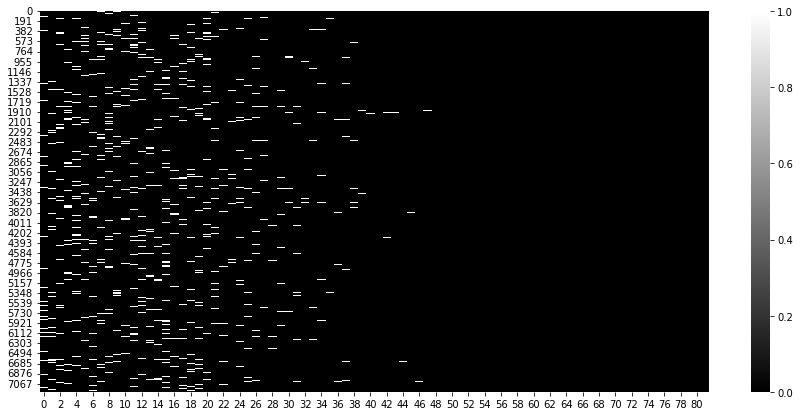

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

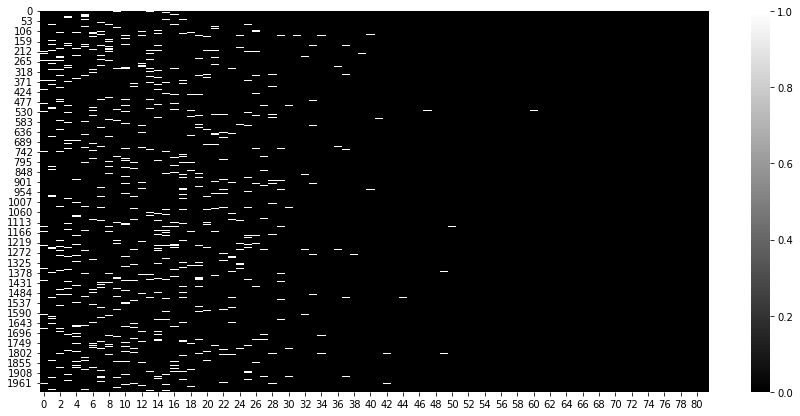

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

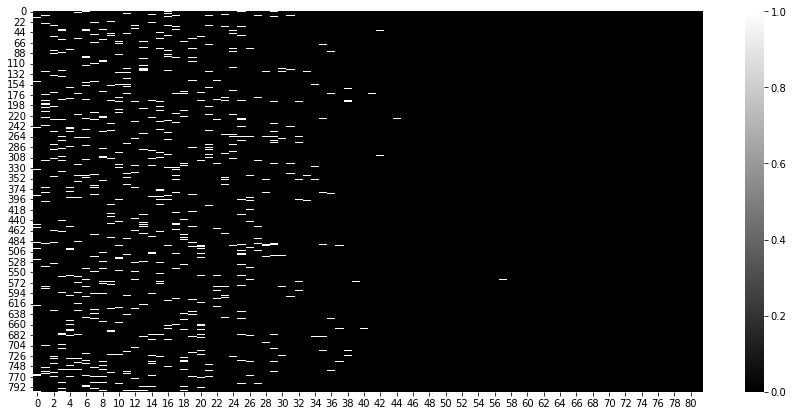

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);